## **Notebook 2 — Hypothesis Testing + Static Visuals (matplotlib, seaborn, plotly)**

**1. Imports & robust path resolution**

In [2]:
#Imports & path setup

import os
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Make plots look nice (optional)
sns.set(style="whitegrid", context="notebook")

# Resolve a robust path to your cleaned csv
# This tries common locations relative to the notebook's folder.
candidate_paths = [
    "../data/processed/spotify_clean.csv",
    "../data/spotify_clean.csv",
    "data/processed/spotify_clean.csv",
    "data/spotify_clean.csv",
]

clean_path = None
for p in candidate_paths:
    if os.path.exists(p):
        clean_path = p
        break

if clean_path is None:
    raise FileNotFoundError(f"Clean CSV not found. Tried: {candidate_paths}")

print("Using cleaned data from:", clean_path)


Using cleaned data from: ../data/processed/spotify_clean.csv


**2. Load data & quick checks**

In [3]:
df = pd.read_csv(clean_path)

# Overview to confirm structure and types
display(df.head())
df.info()

# Key columns we’ll use (some may be missing depending on your source)
needed = ["popularity","danceability","energy","valence","tempo","duration_ms",
          "explicit","track_genre","year"]
missing = [c for c in needed if c not in df.columns]
print("Missing (ok if not used later):", missing)

# Drop obvious duplicates by (track_name, primary_artist) if present
if {"track_name","primary_artist"}.issubset(df.columns):
    before = len(df)
    df = df.drop_duplicates(["track_name","primary_artist"])
    print(f"Deduplicated {before - len(df)} rows by (track_name, primary_artist)")


Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  liveness  valence    tempo  time_signature  \
0         0.676  0.4610  ...    0.3580    0.715   87.917               4   
1         0.420  0.1660  ...    0.1010    0.267   77.489               4   
2         0.438  0.3590  ...    0.1170    0.120   76.332               4   
3         0.266  0.0596  ...    0.1320    0.143  181.740               3   
4         0.618  0.4430  ...    0.0829    0.167  119.949               4   

   track_genre                   artists_list     primary_artist  n_artists  \
0     acoustic                ['Gen Hoshino']        Gen Hoshino          1   
1     acoustic               ['Ben Woodward']       Ben Woodward          1   
2     acoustic  ['Ingrid Michaelson', 'ZAYN']  Ingrid Michaelson          2   
3     acoustic               ['Kina Grannis']       Kina Grannis          1   
4     acoustic           ['Chord Overstreet']   Chord Overstreet          1   

   year  month  
0   NaN    NaN  
1   NaN    NaN  
2   NaN    NaN  
3   NaN    NaN  
4   NaN    NaN  

[5 rows x 26 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

H1 - “Higher danceability and energy are associated with higher popularity.”

- We’re testing whether tracks that are more danceable and energetic tend to score higher on Spotify’s popularity metric (0–100).

- Plots used: Matplotlib scatter + line, Seaborn regplot, Plotly scatter (coloured by genre)




feature  pearson_r        p_value      n
0  danceability   0.087008  4.250414e-136  81133
2       valence   0.011359   1.213777e-03  81133
3         tempo   0.001860   5.962845e-01  81133
1        energy  -0.001509   6.672899e-01  81133

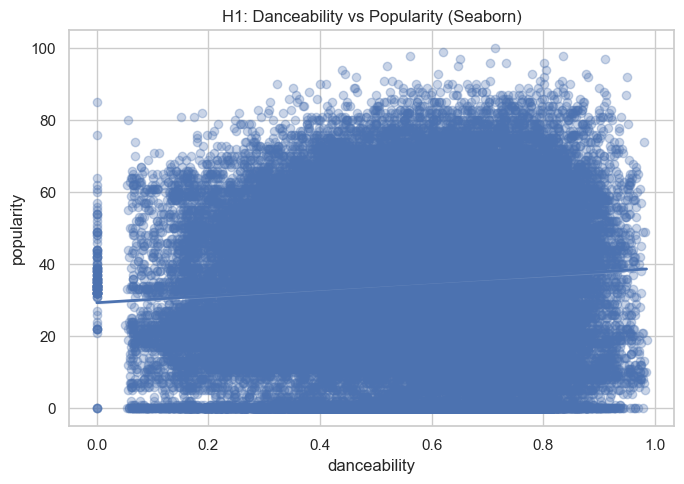

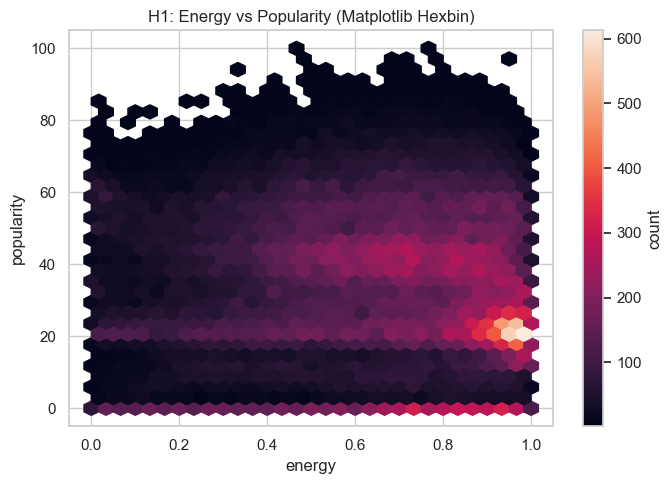

In [4]:
# Higher danceability/energy → higher popularity

# ---- Stats: correlations
features = [c for c in ["danceability","energy","valence","tempo"] if c in df.columns]
corr_rows = []
for col in features:
    s = df[[col,"popularity"]].dropna()
    if len(s) > 30:
        r, p = stats.pearsonr(s[col], s["popularity"])
        corr_rows.append({"feature": col, "pearson_r": r, "p_value": p, "n": len(s)})
corr_df = pd.DataFrame(corr_rows).sort_values("pearson_r", ascending=False)
display(corr_df)

# ---- Light linear model (adds some support for directionality)
# Only include columns that exist
model_cols = [c for c in ["popularity","danceability","energy","valence","tempo","year"] if c in df.columns]
lm_df = df[model_cols].dropna()
if len(lm_df) > 100 and "popularity" in lm_df.columns:
    formula = "popularity ~ " + " + ".join([c for c in lm_df.columns if c != "popularity"])
    lm = smf.ols(formula=formula, data=lm_df).fit()
    print(lm.summary().tables[1])  # coefficients table

# ---- Visuals

# (A) Seaborn: scatter with regression line (danceability vs popularity)
if {"danceability","popularity"}.issubset(df.columns):
    plt.figure(figsize=(7,5))
    sns.regplot(data=df, x="danceability", y="popularity",
                scatter_kws={"alpha":0.3}, line_kws={"linewidth":2})
    plt.title("H1: Danceability vs Popularity (Seaborn)")
    plt.tight_layout()
    plt.show()

# (B) Matplotlib: hexbin (energy vs popularity)
if {"energy","popularity"}.issubset(df.columns):
    plt.figure(figsize=(7,5))
    plt.hexbin(df["energy"], df["popularity"], gridsize=30, mincnt=1)
    plt.xlabel("energy")
    plt.ylabel("popularity")
    plt.title("H1: Energy vs Popularity (Matplotlib Hexbin)")
    plt.colorbar(label="count")
    plt.tight_layout()
    plt.show()

# (C) Plotly: interactive scatter (valence vs popularity)
if {"valence","popularity","track_genre"}.issubset(df.columns):
    fig = px.scatter(df, x="valence", y="popularity", opacity=0.35,
                     color="track_genre",
                     title="H1: Valence vs Popularity by Genre (Plotly)")
    fig.show()


H2 - “Explicit tracks are, on average, less popular than clean tracks.”

- We’re comparing average popularity between explicit = True and explicit = False songs.

n_explicit=6950, n_clean=74183
Welch t=16.978, p=1.49e-63
Cohen's d=0.228  (negative means explicit<clean if mean_explicit < mean_clean)
mean_explicit=38.68, mean_clean=34.26


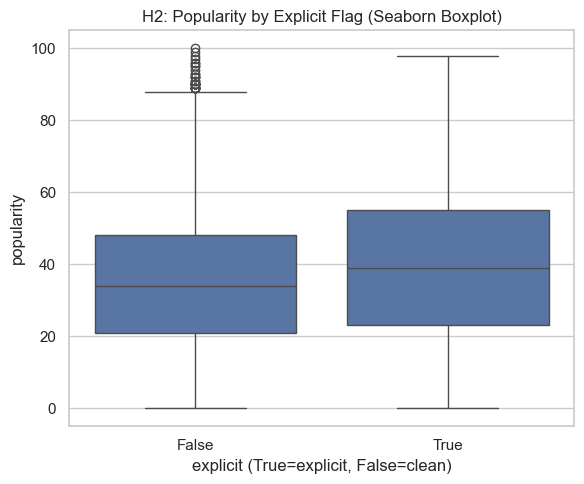

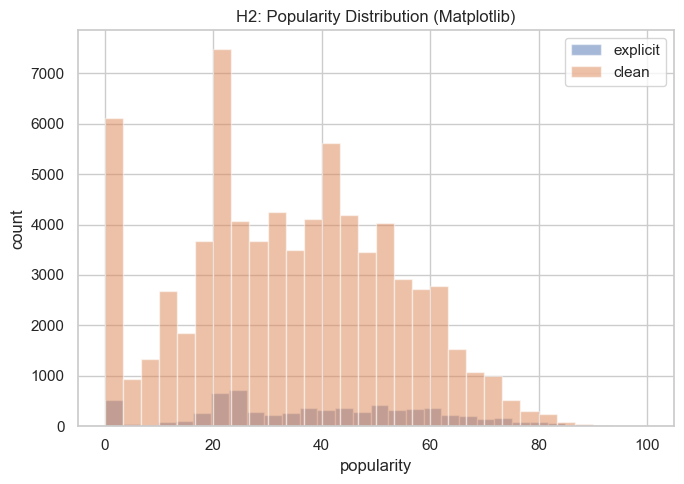

In [5]:
#H2: Explicit tracks have lower popularity than clean tracks

if {"explicit","popularity"}.issubset(df.columns):
    a = df.loc[df["explicit"]==True, "popularity"].dropna()
    b = df.loc[df["explicit"]==False, "popularity"].dropna()

    print(f"n_explicit={len(a)}, n_clean={len(b)}")
    if len(a) > 30 and len(b) > 30:
        # Welch's t-test
        t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)
        # Cohen's d (pooled SD with unequal sizes)
        pooled_sd = np.sqrt(((a.var(ddof=1)*(len(a)-1)) + (b.var(ddof=1)*(len(b)-1))) / (len(a)+len(b)-2))
        cohend = (a.mean() - b.mean()) / pooled_sd

        print(f"Welch t={t_stat:.3f}, p={p_val:.3g}")
        print(f"Cohen's d={cohend:.3f}  (negative means explicit<clean if mean_explicit < mean_clean)")
        print(f"mean_explicit={a.mean():.2f}, mean_clean={b.mean():.2f}")

    # --- Visuals
    # (A) Seaborn boxplot
    plt.figure(figsize=(6,5))
    sns.boxplot(data=df, x="explicit", y="popularity")
    plt.title("H2: Popularity by Explicit Flag (Seaborn Boxplot)")
    plt.xlabel("explicit (True=explicit, False=clean)")
    plt.tight_layout()
    plt.show()

    # (B) Matplotlib histograms
    plt.figure(figsize=(7,5))
    plt.hist(a, bins=30, alpha=0.5, label="explicit")
    plt.hist(b, bins=30, alpha=0.5, label="clean")
    plt.xlabel("popularity")
    plt.ylabel("count")
    plt.title("H2: Popularity Distribution (Matplotlib)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (C) Plotly violin
    fig = px.violin(df.dropna(subset=["explicit","popularity"]),
                    x="explicit", y="popularity", box=True, points="all",
                    title="H2: Popularity by Explicit Flag (Plotly Violin)")
    fig.show()
else:
    print("Column 'explicit' not present; skipping H2.")


H3 - “Popularity peaks near mid-tempo (≈110–130 BPM) and drops at very low/high tempos.”

- We’re checking if tempo has a non-linear relationship with popularity — the “sweet spot” BPM theory.


ANOVA across top genres: F=743.764, p=0


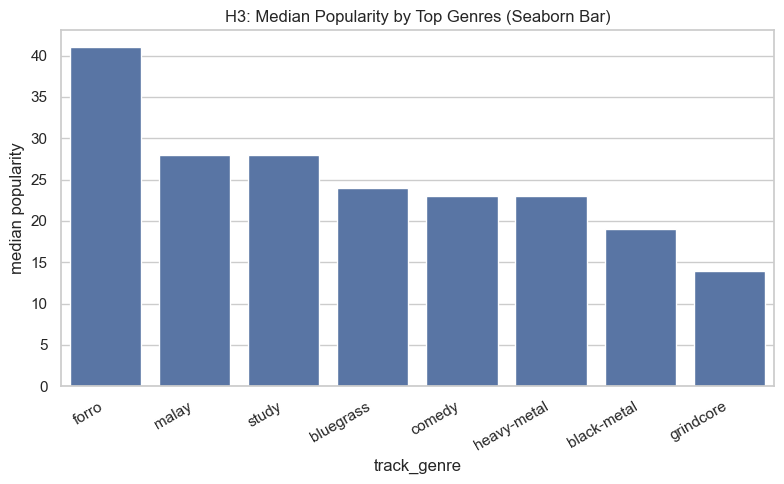

In [6]:
#H3: Median popularity differs by genre + Pop rises in 2010s

if {"track_genre","popularity"}.issubset(df.columns):

    # Top N genres by presence
    genre_counts = df["track_genre"].value_counts()
    top_genres = genre_counts.head(8).index.tolist()
    dfg = df[df["track_genre"].isin(top_genres)].dropna(subset=["popularity"]).copy()

    # --- ANOVA across genres
    # Prepare groups
    groups = [dfg.loc[dfg["track_genre"]==g, "popularity"].values for g in top_genres]
    # Only test if all groups have data
    if all(len(g)>30 for g in groups):
        f_stat, p_val = stats.f_oneway(*groups)
        print(f"ANOVA across top genres: F={f_stat:.3f}, p={p_val:.3g}")
    else:
        print("Not enough data per genre for robust ANOVA; showing visuals only.")

    # --- Visuals

    # (A) Seaborn bar: median popularity by genre
    plt.figure(figsize=(8,5))
    med_pop = dfg.groupby("track_genre")["popularity"].median().sort_values(ascending=False)
    sns.barplot(x=med_pop.index, y=med_pop.values)
    plt.title("H3: Median Popularity by Top Genres (Seaborn Bar)")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("median popularity")
    plt.tight_layout()
    plt.show()

    # (B) Matplotlib: Year trend for top 5 genres (median)
    if "year" in dfg.columns and dfg["year"].notna().any():
        top5 = med_pop.head(5).index.tolist()
        trend = (dfg[dfg["track_genre"].isin(top5)]
                 .dropna(subset=["year"])
                 .groupby(["year","track_genre"])["popularity"]
                 .median()
                 .reset_index())

        plt.figure(figsize=(8,5))
        for g in top5:
            t = trend[trend["track_genre"]==g].sort_values("year")
            plt.plot(t["year"], t["popularity"], label=g)
        plt.title("H3: Median Popularity by Year — Top 5 Genres (Matplotlib)")
        plt.xlabel("year"); plt.ylabel("median popularity")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # (C) Plotly: same trend line (interactive)
        fig = px.line(trend, x="year", y="popularity", color="track_genre",
                      title="H3: Median Popularity by Year — Top 5 Genres (Plotly)")
        fig.show()
else:
    print("Columns 'track_genre' and/or 'popularity' not present; skipping H3.")
